In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd

In [2]:

datadir = 'Data/AAI/'

In [209]:
import glob

def read_mm(mfile):
    hm=np.memmap(mfile, dtype=np.int32, shape=(4,))
    shape = tuple(hm)
    del hm

    mm = np.memmap(mfile, dtype=np.float32, shape=shape)
    mm.shape
    #del mm
    amm = mm[:,:,:,[2, 0, 4, 0, 1]]
    amm = amm[:,:,:, [0,2,4]]
    del mm
    return amm

ifiles = glob.glob('Data/AAI/tiffs_LPS_72h*.mm')
amms = list()
for i in ifiles:
    amms.append(read_mm(i))

amm = np.concatenate(amms)
amm.shape

amm_m = amm.mean(axis=(1,2), keepdims=True)
amm_std = amm.std(axis=(1,2), keepdims=True)
amm = (amm - amm_m)/amm_std

In [210]:
datafile = '/home/cjw/Code/DeepLearning/classifier/Data/images.mm'
labelsfile = '/home/cjw/Code/DeepLearning/classifier/Data/labels.mm'

labels = np.memmap(labelsfile, dtype=np.float32)
data = np.memmap(datafile, dtype=np.float32)
data = data.reshape((-1, 64, 64, 5))
labels = labels.reshape((data.shape[0], -1))
data = data[:,:,:,[0,2,4]]

dm = data.mean(axis=(1,2), keepdims=True)
dstd= data.std(axis=(1,2), keepdims=True)
data = (data - dm)/dstd
data.shape, labels.shape

((35469, 64, 64, 3), (35469, 9))

In [211]:
tf.reset_default_graph()
#dud = tf.get_variable('v1', shape=[2])
sess = tf.Session()


In [212]:
checkpoint = 'Checkpoints/cp-2019-07-01-17-07/checkpoint-24999'
saver = tf.train.import_meta_graph('Checkpoints/cp-2019-07-01-17-07/checkpoint-24999.meta')
saver.restore(sess, checkpoint)

INFO:tensorflow:Restoring parameters from Checkpoints/cp-2019-07-01-17-07/checkpoint-24999


In [213]:
pq = 'dense_1/biasadd'.lower()
print(pq)
g = tf.get_default_graph()
ops = g.get_operations()
for op in ops:
    if pq in op.name.lower():
        print(op.name, op.outputs)

dense_1/biasadd
dense_1/BiasAdd [<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 100) dtype=float32>]
gradients/dense_1/BiasAdd_grad/BiasAddGrad [<tf.Tensor 'gradients/dense_1/BiasAdd_grad/BiasAddGrad:0' shape=(100,) dtype=float32>]
gradients/dense_1/BiasAdd_grad/tuple/group_deps []
gradients/dense_1/BiasAdd_grad/tuple/control_dependency [<tf.Tensor 'gradients/dense_1/BiasAdd_grad/tuple/control_dependency:0' shape=(?, 100) dtype=float32>]
gradients/dense_1/BiasAdd_grad/tuple/control_dependency_1 [<tf.Tensor 'gradients/dense_1/BiasAdd_grad/tuple/control_dependency_1:0' shape=(100,) dtype=float32>]


In [214]:
a = sess.graph.get_tensor_by_name('dense_1/BiasAdd:0')
b = sess.graph.get_tensor_by_name('LeakyRelu_13:0') #'dense_1/BiasAdd:0')
sm = sess.graph.get_tensor_by_name('Softmax:0')

In [215]:
a, b, sm

(<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 100) dtype=float32>,
 <tf.Tensor 'LeakyRelu_13:0' shape=(?, 100) dtype=float32>,
 <tf.Tensor 'Softmax:0' shape=(?, 7) dtype=float32>)

In [216]:
data.max(axis=(0,1,2)), data.min(axis=(0,1,2))

(array([38.00499 , 45.903652, 22.687044], dtype=float32),
 array([-27.450594  ,  -2.3133378 ,  -0.84589547], dtype=float32))

In [217]:
mask = np.any(np.isnan(amm), axis=(1,2,3))
amm = amm[~mask]

In [218]:
gt = labels.argmax(axis=-1)
gt.shape, gt[-10:]

((35469,), array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4]))

In [219]:
images = sess.graph.get_tensor_by_name('Placeholder:0')
d1, r1, p1 = sess.run([a, b, sm], feed_dict={images:data[:, 16:48, 16:48, :]})
d2, r2, p2 = sess.run([a, b, sm], feed_dict={images:amm[:, 16:48, 16:48, :]})

In [220]:
p1x = np.argmax(p1, axis=-1)
p2x = np.argmax(p2, axis=-1)
p1x.shape, p2x.shape

((35469,), (50935,))

In [221]:
df1 = pd.DataFrame({'sm':p1x, 'smmax':p1.max(axis=-1), 'gt':gt})
df2 = pd.DataFrame({'sm':p2x, 'smmax':p2.max(axis=-1)}) 

gtmap = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 8:0, 7:4}
df1['gtc'] = df1['gt'].map(gtmap)


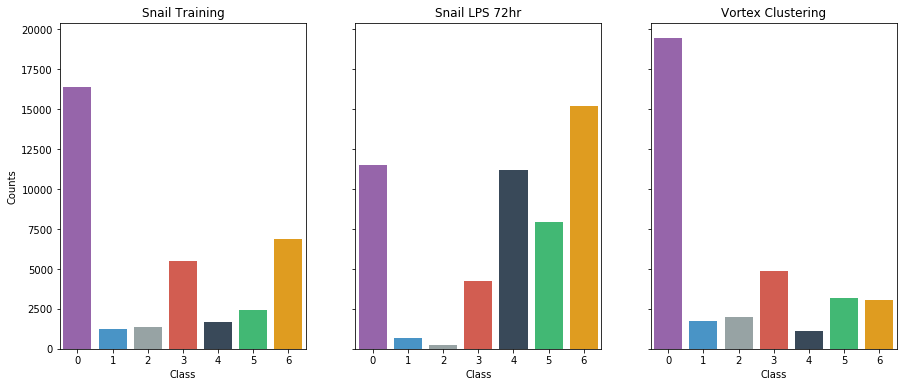

In [222]:
import seaborn as sns 

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", "orange"]

fig, ax = plt.subplots(1, 3, sharex='col', sharey='row')
fig.set_size_inches(15,6)
#plt.subplot(1,3,1)
sns.countplot(x='sm', data=df1, palette=flatui, ax=ax[0])
ax[0].set_title("Snail Training")
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Counts')
#plt.subplot(1,3,2)
sns.countplot(x='sm', data=df2, palette=flatui, ax=ax[1])
ax[1].set_title("Snail LPS 72hr")
ax[1].set_xlabel('Class')
ax[1].set_ylabel('')
#plt.subplot(1,3,3)
sns.countplot(x='gtc', data=df1, palette=flatui, ax=ax[2])
ax[2].set_title("Vortex Clustering")
ax[2].set_xlabel('Class')
ax[2].set_ylabel('')

plt.savefig('Graphics/counts_lps72.pdf')

In [136]:
from sklearn import metrics
print(metrics.classification_report(df1['gtc'], df1['sm']))

              precision    recall  f1-score   support

           0       0.93      0.78      0.85     19450
           1       0.61      0.43      0.51      1729
           2       0.70      0.47      0.56      2015
           3       0.69      0.77      0.73      4899
           4       0.45      0.65      0.53      1143
           5       0.52      0.41      0.46      3152
           6       0.35      0.78      0.48      3081

   micro avg       0.71      0.71      0.71     35469
   macro avg       0.61      0.61      0.59     35469
weighted avg       0.76      0.71      0.72     35469



In [86]:
import umap

emb1 = umap.UMAP(n_neighbors=12, min_dist=.1).fit_transform(r1)
emb2 = umap.UMAP(n_neighbors=12, min_dist=.1).fit_transform(r2)
df1['x'] = emb1[:,0]
df1['y'] = emb1[:, 1]

df2['x'] = emb2[:,0]
df2['y'] = emb2[:, 1]

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/deep/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/deep/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(par

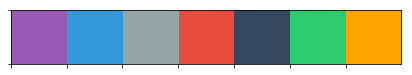

In [87]:
import seaborn as sns


sns.palplot(sns.color_palette(flatui))

def scatter(df):
    df['s'] = df['smmax']
    df['s'] *= 10
    df['s'] = df['s'].map(int)

    plt.figure(figsize=(8,8))
    sns.scatterplot(x='x', y='y', hue='sm', s=4,
                    alpha=.9, edgecolor=None,
                    palette=flatui, legend='full', data=df)
    


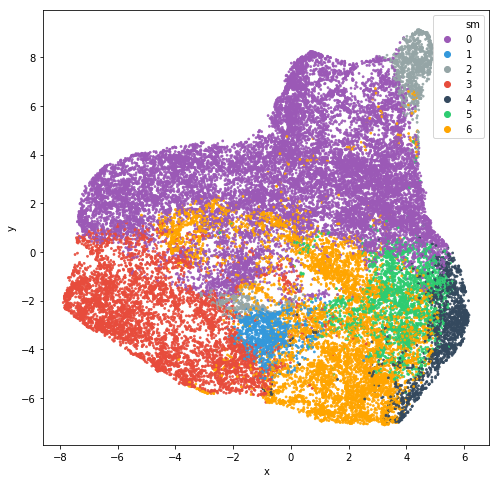

In [88]:
scatter(df1)

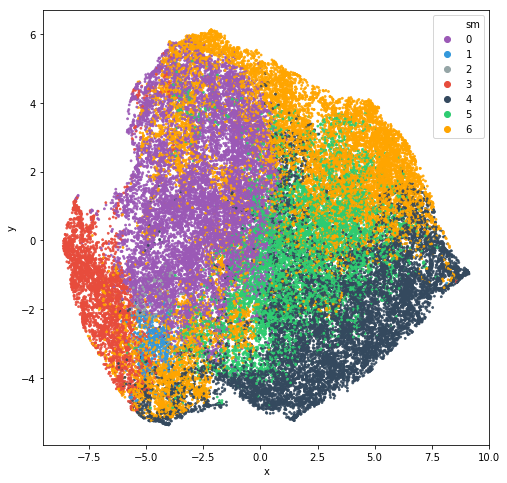

In [89]:
scatter(df2)

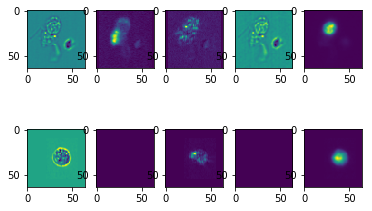

In [16]:
n = 38

for i in range(5):
    plt.subplot(2,5,i + 1)
    plt.imshow(data[n,:,:,i])
    plt.subplot(2,5,i + 1 + 5)
    plt.imshow(amm[n,:,:,i])

In [35]:
cn = 2

def gallery(df, images, cn, threshold):
    xdf = df[df['smmax'] > threshold]
    cnums = xdf[xdf['sm'] == cn].index
    cnums = np.array(cnums)
    np.random.shuffle(cnums)

    index = 1
    counter = 0

    if len(cnums) > 20:
        num_x = 20
    else:
        num_x = len(cnums)

    print(num_x)
    plt.figure(figsize=(4,1.3*num_x))
    for inum in cnums:
        #print(inum)
        #print(p[inum].max())
        for i in range(3):
            plt.subplot(num_x,3,index)
            plt.imshow(images[inum,:,:,i], cmap='gray')
            plt.axis('off')
            index += 1
        counter += 1
        if counter >= 20:
            break

    xdf[xdf['sm'] == cn].head()
    

20
20
20
20
20
20
20
20
20
20
20
20
20
20


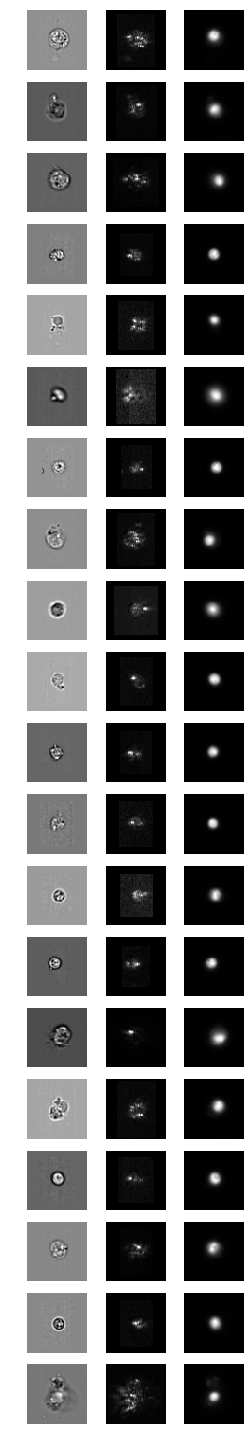

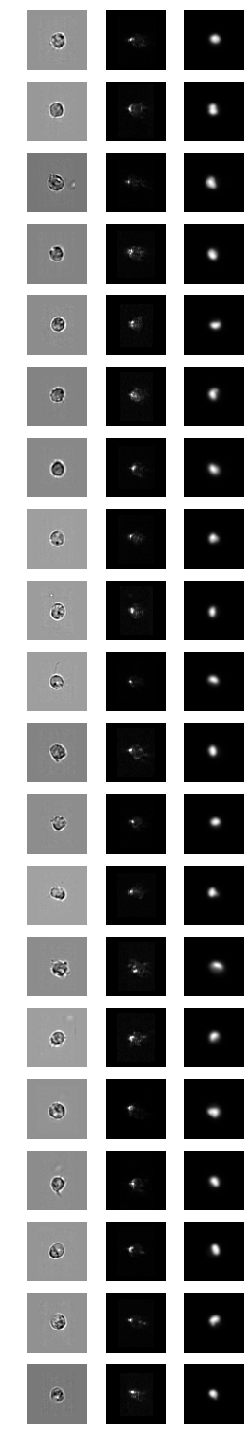

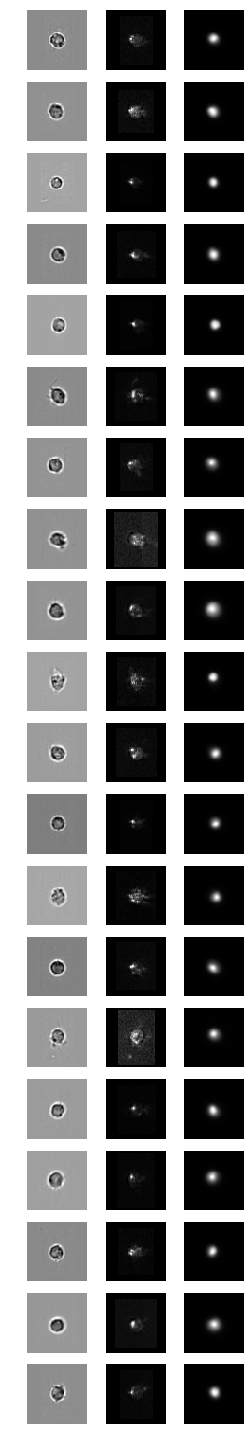

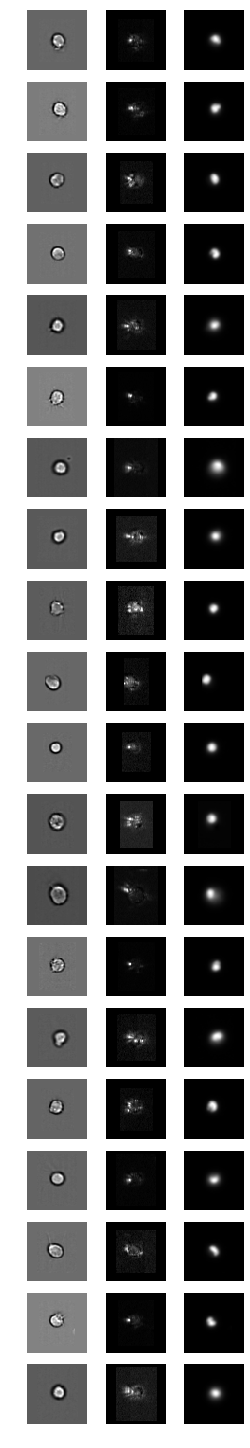

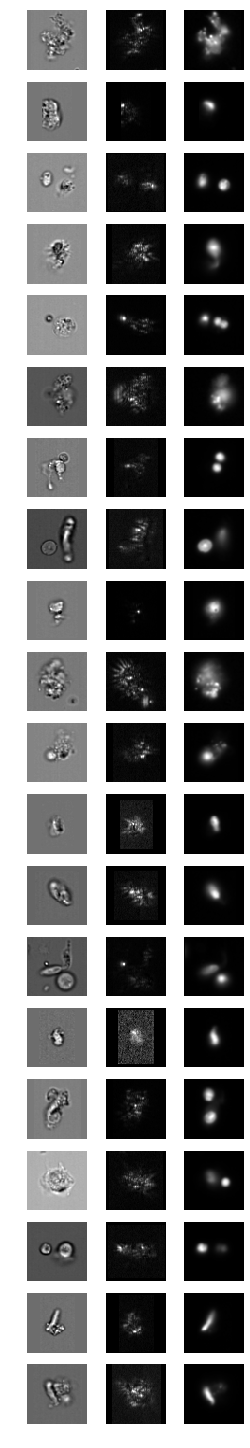

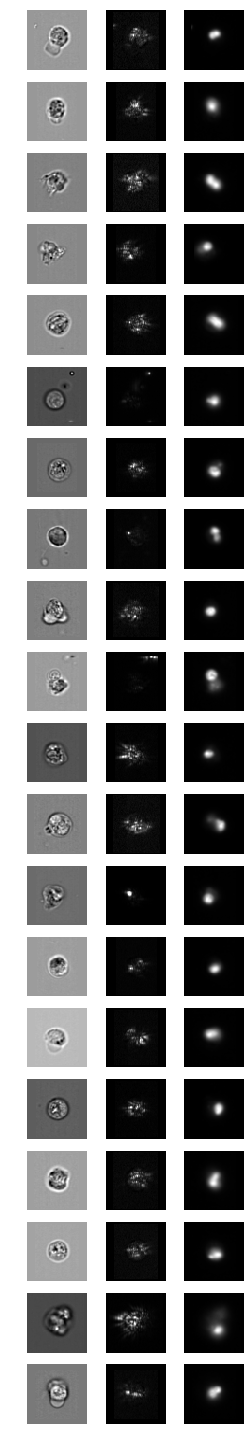

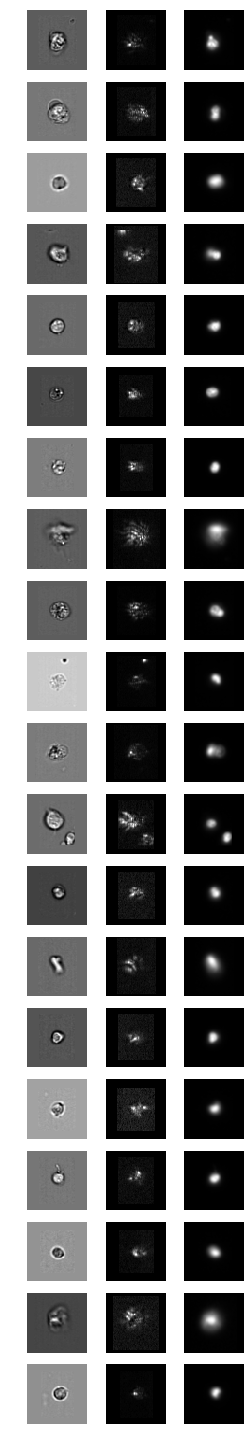

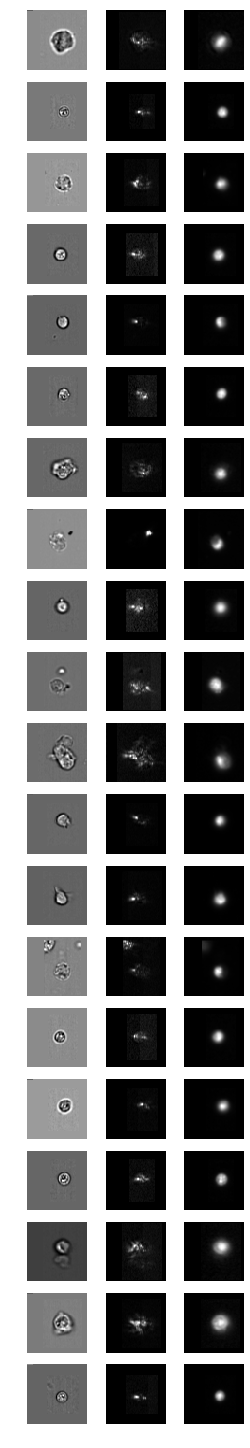

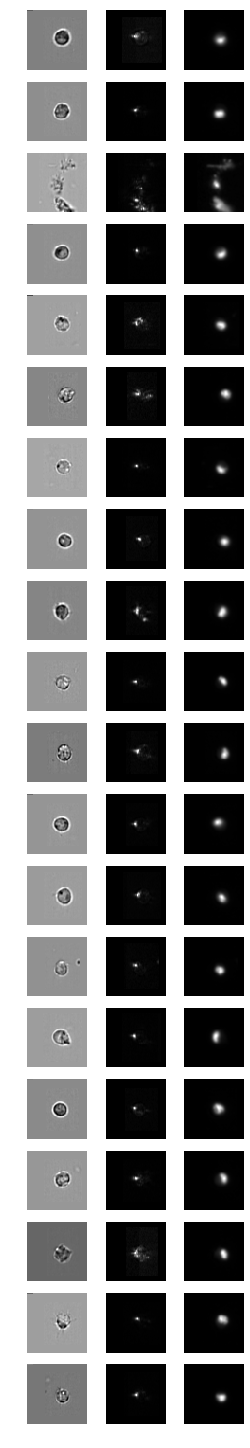

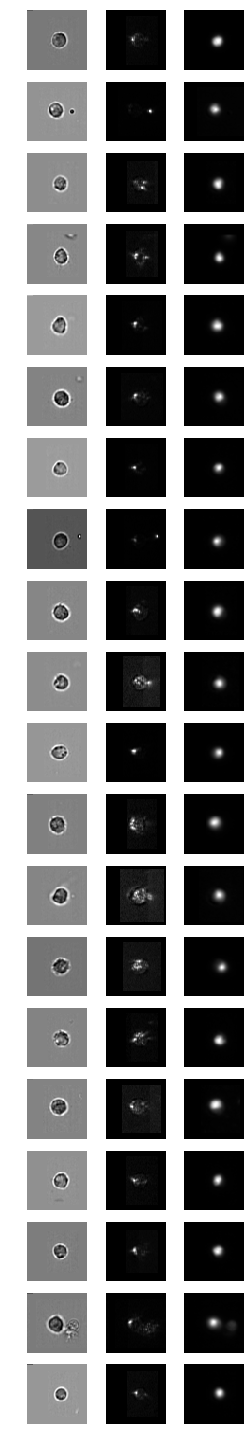

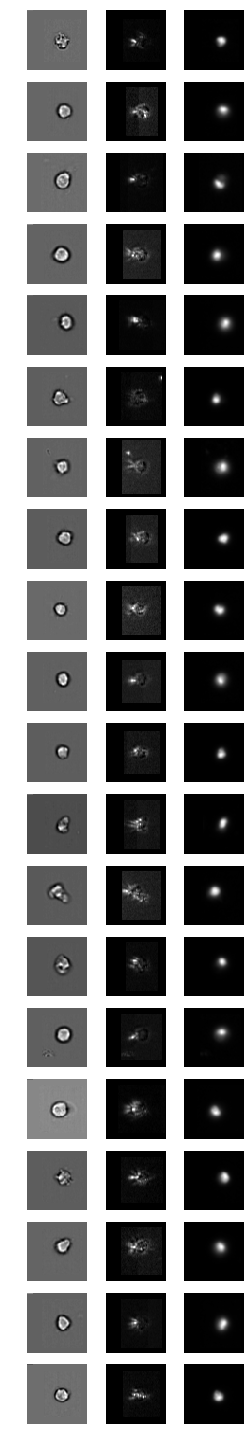

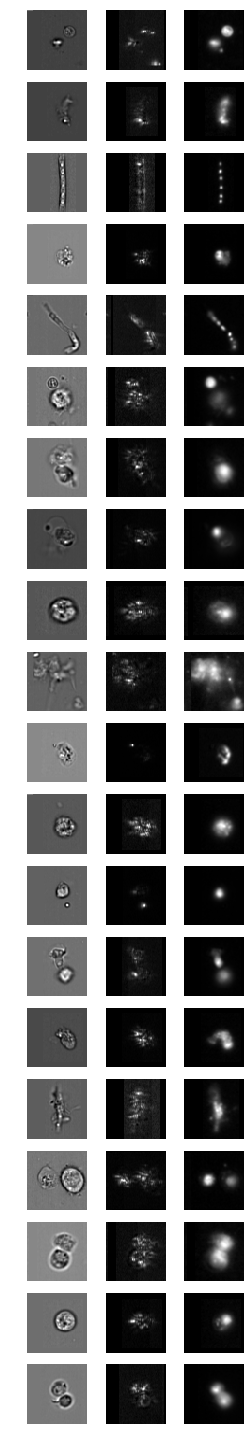

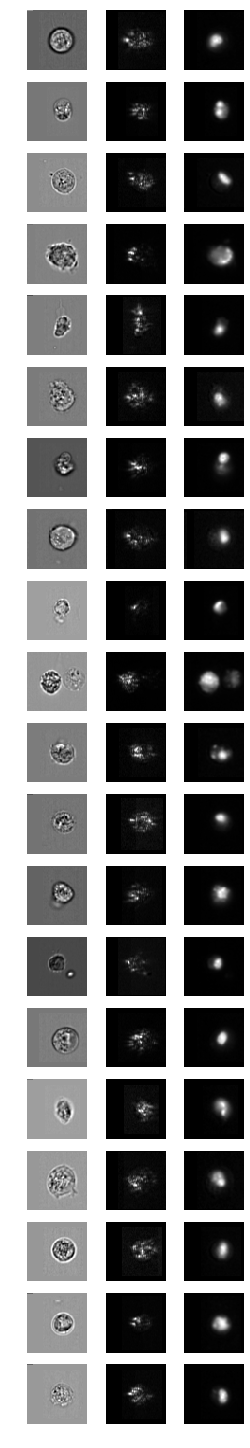

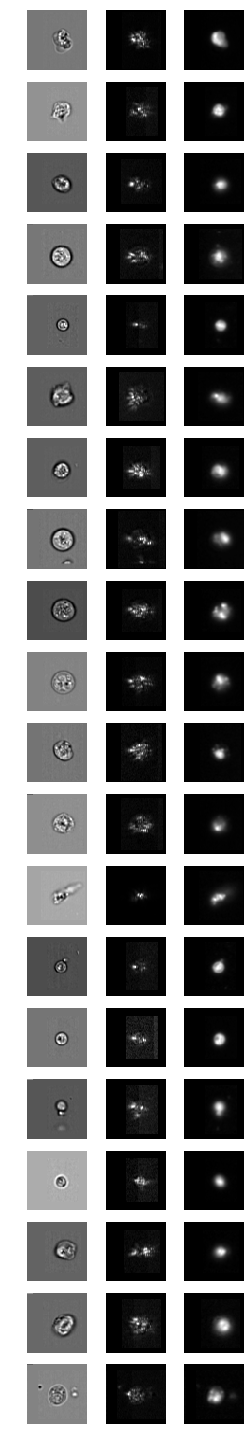

In [137]:
import os

plt.ioff()
gdir = 'Graphics/gallery_fss24/'
try:
    os.makedirs(gdir)
except:
    print('can\'t make directory')
    
for i in range(df1['gtc'].max() + 1):
    gallery(df1, data, i, .85)
    fname = '{}{}_class_{:02d}.pdf'.format(gdir, 'set-1', i)
    plt.savefig(fname, bbox_inches='tight')
    
for i in range(df2['sm'].max() + 1):
    gallery(df2, amm, i, .85)
    fname = '{}{}_class_{:02d}.pdf'.format(gdir, 'set-2', i)
    plt.savefig(fname, bbox_inches='tight')
    
plt.ion()

20


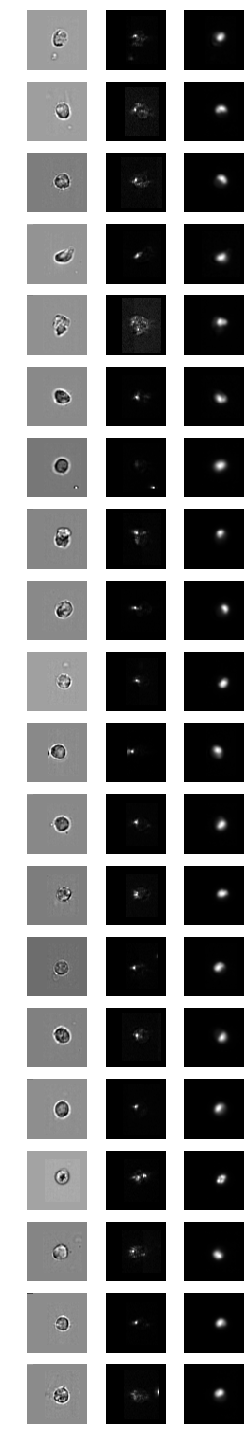

In [37]:
gallery(df2, amm, 1, .85)

In [65]:
from sklearn.manifold import TSNE
ts2 = TSNE().fit_transform(r2)

In [66]:
ts1 = TSNE().fit_transform(r1)

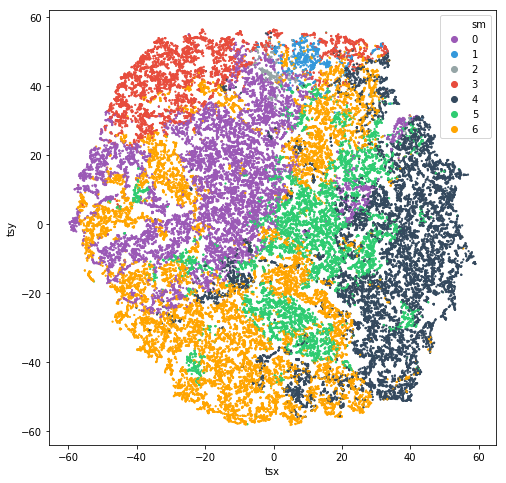

In [69]:

df2['tsx'] = ts2[:,0]
df2['tsy'] = ts2[:,1]

plt.figure(figsize=(8,8))
sns.scatterplot(x='tsx', y='tsy', hue='sm', s=2, edgecolor=None, palette=flatui, data=df2)

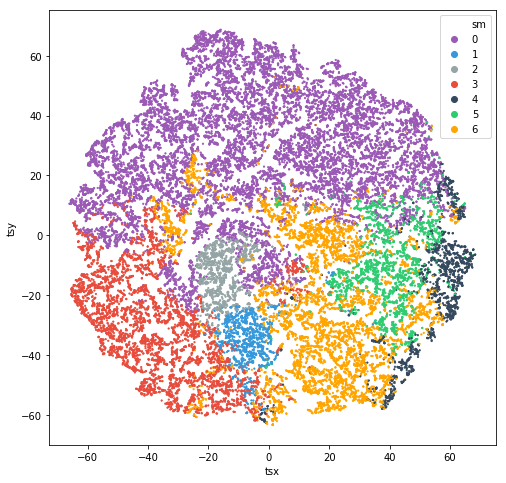

In [70]:
df1['tsx'] = ts1[:,0]
df1['tsy'] = ts1[:,1]

plt.figure(figsize=(8,8))
sns.scatterplot(x='tsx', y='tsy', hue='sm', s=2, edgecolor=None, palette=flatui, data=df1)